# Clean Image Generation

In [1]:
import time
import os
import cv2
import imageio 
import numpy as np
import skimage
import skimage.io as sio
import torch.multiprocessing as mp
from PIL import Image
import json
import ffmpeg
import scipy.io as io

In [2]:
def read_video(videoPath):
    # read video
    out, _ = (
    ffmpeg
    .input(videoPath)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
    )
    # read matedata of video
    probe = ffmpeg.probe(videoPath)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    width = int(video_info['width'])
    height = int(video_info['height'])
    # Convert to Numpy array
    video = (
    np
    .frombuffer(out,np.uint8)
    .reshape([-1, height, width, 3])
    )
    return video

In [3]:
def get_max_occur_number(arr):
    bc = np.bincount(arr)
    argmax = np.argmax(bc)
    count = bc[argmax]
    return argmax,count

def job(q,y,Range):
    w1,w2,h1,h2 = Range
    percent_min = []
    percent_max = []
    maps = np.zeros((int(h2-h1)*int(w2-w1),101))
    for h in range(int(h1),int(h2)):
        for w in range(int(w1),int(w2)):
            argmax,count = get_max_occur_number(y[:,h,w])
            index = [i for (i, j) in enumerate(sorted(y[:,h,w])) if j == argmax ]
            percent_min.append(index[0]/len(y[:,h,w])*100)
            percent_max.append(index[-1]/len(y[:,h,w])*100)
    for i in range(int(h2-h1)*int(w2-w1)):
        for j in range(0,101):
            if j >= percent_min[i] and j <= percent_max[i]:
                maps[i,j]=1
    print('range {w1} to {w2}, {h1} to {h2} is being stored...'.format(w1=w1,w2=w2,h1=h1,h2=h2))
    q.put(maps)
    print('range {w1} to {w2}, {h1} to {h2} was stored successfully...'.format(w1=w1,w2=w2,h1=h1,h2=h2))

def computer_percentile(y):
    _,H,W = y.shape

    q1 = mp.SimpleQueue()
    q2 = mp.SimpleQueue()
    q3 = mp.SimpleQueue()
    q4 = mp.SimpleQueue()
    q5 = mp.SimpleQueue()
    q6 = mp.SimpleQueue()
    q7 = mp.SimpleQueue()
    q8 = mp.SimpleQueue()

    R1 = (W/4*0, W/4*1, 0,   H/2 )
    R2 = (W/4*1, W/4*2, 0,   H/2 )
    R3 = (W/4*2, W/4*3, 0,   H/2 )
    R4 = (W/4*3, W/4*4, 0,   H/2 )
    R5 = (W/4*0, W/4*1, H/2,  H  )
    R6 = (W/4*1, W/4*2, H/2,  H  )
    R7 = (W/4*2, W/4*3, H/2,  H  )
    R8 = (W/4*3, W/4*4, H/2,  H  )

    p1 = mp.Process(target=job,args=(q1,y,R1))
    p2 = mp.Process(target=job,args=(q2,y,R2))
    p3 = mp.Process(target=job,args=(q3,y,R3))
    p4 = mp.Process(target=job,args=(q4,y,R4))
    p5 = mp.Process(target=job,args=(q5,y,R5))
    p6 = mp.Process(target=job,args=(q6,y,R6))
    p7 = mp.Process(target=job,args=(q7,y,R7))
    p8 = mp.Process(target=job,args=(q8,y,R8))

    p1.deamon = True
    p2.deamon = True
    p3.deamon = True
    p4.deamon = True
    p5.deamon = True
    p6.deamon = True
    p7.deamon = True
    p8.deamon = True

    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()

    map1 = q1.get()
    map2 = q2.get()
    map3 = q3.get()
    map4 = q4.get()
    map5 = q5.get()
    map6 = q6.get()
    map7 = q7.get()
    map8 = q8.get()
    maps = np.concatenate((map1,map2,map3,map4,map5,map6,map7,map8),axis=0)
    percentile = np.argmax([np.sum(maps[:,i]) for i in range(0,101)])
    return percentile
def RGB2YCbCr(rgb):
        m = np.array([[ 0.29900, -0.16874,  0.50000],
                    [0.58700, -0.33126, -0.41869],
                    [ 0.11400, 0.50000, -0.08131]])
        ycbcr = np.dot(rgb,m)
        ycbcr[:,:,1:]+=128.0
        return ycbcr.astype('uint8')

In [4]:
video_name = 'rain_s270.mp4'
frame_number = 100 # adapt this to get better result
rgb = read_video('../Movies/data/stabilization/'+video_name)# Change to your video path
rgb = rgb[:frame_number]

In [6]:
ycbcr = RGB2YCbCr(rgb)
y  = ycbcr[:,:,:,0]

end = time.time()
percentile = computer_percentile(y) 
print(time.time()-end)
print('Saving image...')
print(time.time()-end)
final = np.percentile(rgb,percentile,axis=0).astype('uint8')
Image.fromarray(final).save('/Users/stevewong/LAB/no-rain/'+video_name[:-4]+'_final.png')

print(time.time()-end)   
print('Next')

187.1345009803772
Next


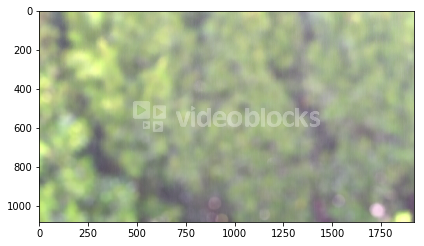

In [8]:
sio.imshow(final)